In [1]:
import numpy as np
from math import sqrt
from pprint import pprint
from sklearn import datasets, linear_model, metrics
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt

In [4]:
# Carga de datos.
datos = datasets.fetch_california_housing()
# print(datos)
X = datos.data
y = datos.target
print('Dimensiones de X: ', np.shape(X))
# print(y)

Dimensiones de X:  (20640, 8)


In [13]:
pprint(X)
pprint(y)

array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   3.6333    ,    7.        ,    7.2434555 , ...,    2.9921466 ,
          39.11      , -121.05      ],
       [   3.463     ,    8.        ,    6.36363636, ...,    2.89800443,
          39.08      , -121.04      ],
       [   3.0781    ,    7.        ,    5.4875    , ...,    3.075     ,
          39.09      , -121.        ]])
array([4.526, 3.585, 3.521, ..., 1.702, 2.017, 1.625])


In [5]:
X = X[:10000, :]
y = y[:10000]

In [6]:
# # Métricas de evaluación.
metricas = {
  'MAE':  'neg_mean_absolute_error',
  'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(metrics.mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False),
  'R2':   'r2',}

In [7]:
# 1) Partición de datos externa
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_training))

(8000, 8)


In [8]:
# 2) Extracción de características (imputación de valores ausentes, stand, outliers...)
# 3) Selección de atributos
# 4) Estandarización de los datos de entrenamiento
standardizer = preprocessing.StandardScaler()
stdr_trained = standardizer.fit(X_training)
X_stdr = stdr_trained.transform(X_training)

In [10]:
# 5) Construcción del algoritmo de aprendizaje.
reg = linear_model.LinearRegression(fit_intercept=True, positive=False)

In [11]:
# 5.1) Validación cruzada interna

# Extraer directamente resultados del error para cada bolsa, en lugar de las predicciones
cross_val_results = cross_validate(reg, X_stdr, y_training, 
                                    cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)
#print("cross_val_MAE:   %0.4f +/- %0.4f" % (-cross_val_results.mean(), cross_val_results.std()))
pprint(cross_val_results)

{'fit_time': array([0.01416063, 0.0010004 , 0.00100064, 0.00100064, 0.00150108]),
 'score_time': array([0.00101519, 0.00050068, 0.00050044, 0.00100088, 0.0010035 ]),
 'test_MAE': array([-0.53923398, -0.58081829, -0.54006238, -0.56532952, -0.54539839]),
 'test_MAPE': array([-33.39593769, -38.57433109, -33.43840396, -32.47668208,
       -33.74240717]),
 'test_R2': array([ 0.59171403, -1.98356784,  0.55366186,  0.57349145,  0.6195684 ]),
 'test_RMSE': array([-0.73915783, -2.04768579, -0.77531208, -0.76936771, -0.72077636])}


In [12]:
# 5.2) Entrenamiento con todos los datos para obtener los coeficientes del modelo.
model = reg.fit(X_stdr, y_training)

# Obtención de los coeficientes del modelo.
w = model.coef_
print('Model coeficients: \n', w)

# Obtención del término independiente del modelo.
w_0 = model.intercept_
print('\nTérmino independiente: ', w_0)

Model coeficients: 
 [ 0.85462881  0.0641802  -0.30793579  0.35439885 -0.00209462 -0.04076649
 -0.87650105 -0.71065945]

Término independiente:  2.0502766112502044


In [14]:
# ---- PREDICCIÓN ---- #

In [15]:
# 6) Extracción de las características de test
# 7) Selección de los atributos de test 
# 8) Estandarización de las característiacs de test
X_test_stdr = stdr_trained.transform(X_testing)

In [17]:
# 9) Predicción del conjunto de test
y_pred_test = model.predict(X_test_stdr)
print(y_pred_test)

[1.63466427 2.11606728 3.23366144 ... 2.13866355 1.02429649 1.80739308]


In [18]:
# Cálculo de las métricas de evaluación.
MAE = metrics.mean_absolute_error(y_testing, y_pred_test)
MSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=True)
RMSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=False)
MAPE = metrics.mean_absolute_percentage_error(y_testing, y_pred_test)
R2 = metrics.r2_score(y_testing, y_pred_test)

print('MAE:  %.4f' % MAE)
print('MSE: %.4f' % MSE)
print('RMSE: %.4f' % RMSE)
print('MAPE: %.4f' % MAPE)
print('R2:   %.4f' % R2)

MAE:  0.5513
MSE: 0.5440
RMSE: 0.7376
MAPE: 0.3397
R2:   0.5873


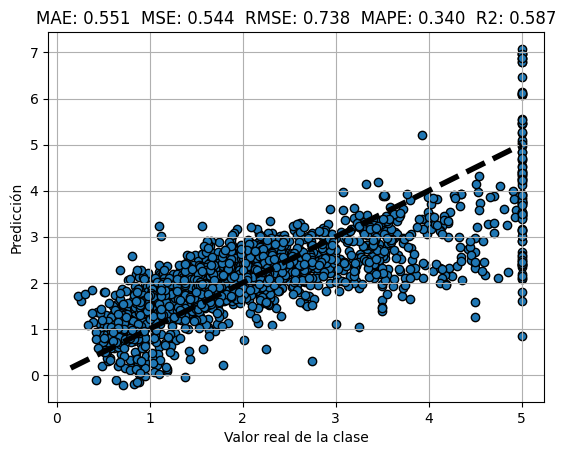

In [19]:
# Gráfica de realidad vs. predicción.
fig, ax = plt.subplots()
ax.scatter(y_testing, y_pred_test, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Valor real de la clase')
ax.set_ylabel('Predicción')
plt.title("MAE: %.3f  MSE: %.3f  RMSE: %.3f  MAPE: %.3f  R2: %.3f" %
          (MAE,MSE,RMSE,MAPE,R2))
plt.grid()
plt.show()